## Embeddings Finetuning

Improve searching through your knowledge base by adapting embeddings to your domain and data. This solution will fine-tune an embedding LLM and helps you host your own private model for generating vectors.

This sample notebook shows you how to finetune embeddings from AWS Marketplace 

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to For Seller to update: Embeddings-Finetuning. 

#### Contents:
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure dataset](#B.-Configure-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Execute the training process](#3.-Execute-optimization-model)
	1. [Execute model](#A.-Execute-model)
    1. [Visualize Output](#B.-Inspect-the-Output-in-S3)
1. [Deploy model and verify results](#4.-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
	1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Delete endpoint](#E.-Delete-Endpoint)
1. [Perform batch inference](#5.-Perform-batch-inference)
1. [Clean-up](#6.-Clean-up)
   1. [Delete the model](#A.-Delete-the-model)
   1. [Unsubscribe to the listing (optional)](#B.Unsubscribe-to-the-listing-(optional))


#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page **Embeddings-Finetuning**
1. On the AWS Marketplace listing,  click on **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn**. This is the algorithm ARN that you need to specify while training a custom ML model. Copy the ARN corresponding to your region and specify the same in the following cell.

In [142]:
algo_arn = "embeddings-finetuning-listing"


### 2. Prepare dataset

In [143]:
import os
import json 
import uuid
import boto3
import pickle
import base64
import tarfile
from pprint import pprint
from PIL import Image

import numpy as np
import pandas as pd

import urllib.request
from urllib.parse import urlparse

import sagemaker as sage
from sagemaker import ModelPackage
from sagemaker import get_execution_role

#### A. Dataset format expected by the algorithm

The algorithm requires data in the format as described for best results:
* Input File name should be train.zip
* The input data files must contain a csv file(train.csv) containing question and answer pairs(columns:Question, Answer)and a json file containing hyperparameters( {"BATCH_SIZE":10,"EPOCHS":1} )
* For detailed instructions, please refer sample notebook and algorithm input details.

#### B. Configure dataset

In [144]:
training_dataset="Input/train.zip"

#### C. Upload datasets to Amazon S3

In [145]:
role = get_execution_role()

In [146]:
sagemaker_session = sage.Session()

bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-786796469737'

In [147]:
# training input location
common_prefix = "embeddings-finetuning"
training_input_prefix = common_prefix + "/training-input-data"
TRAINING_WORKDIR = "Input" #Input directory in Jupyter Server
training_input = sagemaker_session.upload_data(TRAINING_WORKDIR, key_prefix=training_input_prefix) #uploads data from jupyter server to S3
print("Training input uploaded to " + training_input)

Training input uploaded to s3://sagemaker-us-east-2-786796469737/embeddings-finetuning/training-input-data


### 3. Execute the training process

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to execute a training pipeline to get clean sentiment class labels using clean-sentiment-classification-labels Algorithm. 

In [148]:
output_location = 's3://{}/embeddings-finetuning/{}'.format(bucket, 'Output')

#### A. Execute model

For information on creating an `Estimator` object, see [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In [149]:
training_instance_type="ml.g4dn.xlarge"

In [ ]:
#Create an estimator object for running a training job
estimator = sage.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="embeddings-finetuning-algo",
    role=role,
    train_instance_count=1,
    train_instance_type=training_instance_type,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sagemaker_session,
    instance_count=1,
    instance_type=training_instance_type
)

#Run the training job.
estimator.fit({"training": training_input})

2023-12-11 12:41:42 Starting - Starting the training job...
2023-12-11 12:41:58 Starting - Preparing the instances for trainingProfilerReport-1702298502: InProgress
......
2023-12-11 12:42:57 Downloading - Downloading input data...
2023-12-11 12:43:35 Training - Downloading the training image............
2023-12-11 12:45:36 Training - Training image download completed. Training in progress...==========
== CUDA ==
CUDA Version 11.7.1
Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license
A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.
Extracting the input data
Cuda Available
#015Epoch: 100%|██████████| 5/5 [11:03<00:00, 132.35s/it]#

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

In [161]:
#output is available on following path
estimator.output_path

In [152]:
parsed_url = urlparse(estimator.output_path)
bucket_name = parsed_url.netloc
file_key = parsed_url.path[1:]+'/'+estimator.latest_training_job.job_name+'/output/'+"model.tar.gz"

s3_client = sagemaker_session.boto_session.client('s3')
response = s3_client.get_object(Bucket = sagemaker_session.default_bucket(), Key = file_key)

In [153]:
bucketFolder = estimator.output_path.rsplit('/')[3] +'/Output/'+ estimator.latest_training_job.job_name+'/output/'+"model.tar.gz"

In [154]:
s3_conn = boto3.client("s3")
bucket_name=bucket
with open('output.tar.gz', 'wb') as f:
    s3_conn.download_fileobj(bucket_name, bucketFolder, f)
    print("Output file loaded from bucket")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


Output file loaded from bucket


In [155]:
with tarfile.open('output.tar.gz') as file:
    file.extractall('./result')

#### B. Visualize output

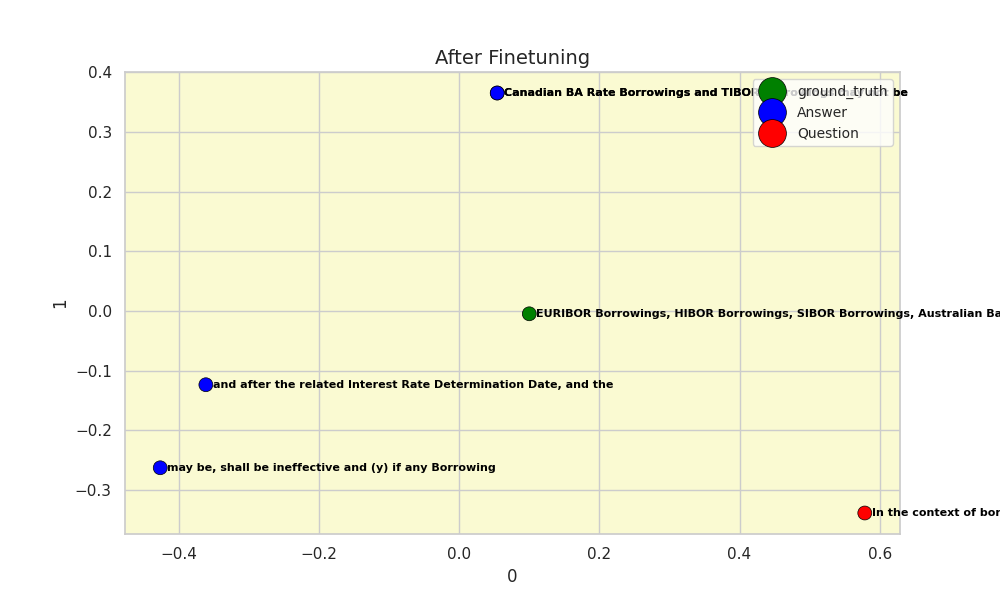

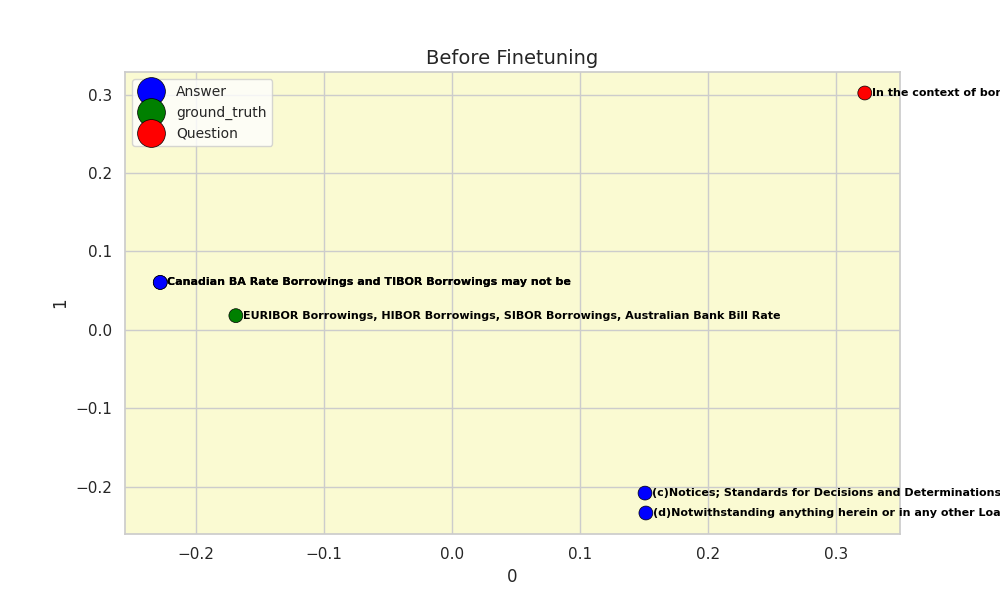

In [157]:
zip_file_path = "result/output.zip"

extracted_dir = "result/extracted_images"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

png_files = [file for file in os.listdir(extracted_dir) if file.lower().endswith('.png')]

for png_file in png_files:
    png_file_path = os.path.join(extracted_dir, png_file)

    with Image.open(png_file_path) as img:
        img.show()



In [159]:
zip_file_path = 'result/output.zip'
csv_file_name = 'data.csv'  

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if csv_file_name in zip_ref.namelist():
        with zip_ref.open(csv_file_name) as csv_file:
            df = pd.read_csv(csv_file)
            
    else:
        print(f"The CSV file '{csv_file_name}' does not exist in the zip file.")


In [160]:
df

,Metric,Value
0,Hit Rate Before,0.811644
1,Hit Rate After,0.876712
2,Avg Distance Before,0.534757
3,Avg Distance After,0.442171


### 4: Deploy model and verify results

In [130]:
model_name='embeddings-finetuning-listing'

content_type='application/zip'

real_time_inference_instance_type='ml.m5.2xlarge'
batch_transform_inference_instance_type='ml.m5.2xlarge'

#### A. Deploy trained model

In [131]:
from sagemaker.predictor import csv_serializer
predictor = estimator.deploy(1, real_time_inference_instance_type)

..........
---------!

#### B. Create input payload

In [132]:
file_name = "Input/test_data.zip"

#### C. Perform real-time inference

In [133]:
output_file_name = "output/output.zip"

In [134]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name $predictor.endpoint_name \
    --body fileb://$file_name \
    --content-type $content_type \
    --region $sagemaker_session.boto_region_name \
    --cli-read-timeout 1200 \
    $output_file_name

{
    "ContentType": "application/zip",
    "InvokedProductionVariant": "AllTraffic"
}


#### D. Visualize output

In [135]:
zip_file_path = 'output/output.zip'
csv_file_name = 'embeddings.csv'  

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if csv_file_name in zip_ref.namelist():
        with zip_ref.open(csv_file_name) as csv_file:
            df = pd.read_csv(csv_file)
            
    else:
        print(f"The CSV file '{csv_file_name}' does not exist in the zip file.")


In [136]:
df

,text,text_embeds
0,What are the potential consequences for the Is...,[ 3.71258296e-02 -1.68069508e-02 -4.54866290e-...
1,"How can fluctuations in MAPCs, Trips, Adjusted...",[-3.17668319e-02 -2.85530910e-02 -1.23619400e-...
2,"How is ""Disability"" defined in the context of ...",[-2.24810205e-02 -2.04069689e-02 -5.77819869e-...
3,"According to the context information, what is ...",[-1.97536666e-02 -2.96230633e-02 -3.52535979e-...
4,How can the 2025 Convertible Notes be redeemed...,[-5.27026877e-02 -7.66259134e-02 6.09034114e-...
...,...,...
287,In the event of a breach or threatened breach ...,[ 2.67439540e-02 -9.09338519e-03 2.00641192e-...
288,"In Section 5.06, what are the requirements for...",[-9.08927433e-03 -3.74701656e-02 2.61912048e-...
289,What are the specific provisions that require ...,[ 2.06268486e-02 -5.43972328e-02 -3.67730670e-...
290,According to the Supplemental Release Agreemen...,[-3.73779498e-02 -1.78132746e-02 1.52176376e-...


#### E. Delete the endpoint

In [137]:
predictor.delete_endpoint(delete_endpoint_config=True)

### 5. Perform Batch inference

In [162]:
#upload the batch-transform job input files to S3
transform_input_folder = "Input/test_data.zip"
transform_input = sagemaker_session.upload_data(transform_input_folder, key_prefix=model_name) 
print("Transform input uploaded to " + transform_input)

In [139]:
#Run the batch-transform job
transformer = estimator.transformer(1, batch_transform_inference_instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

..............
............................................==========
== CUDA ==
CUDA Version 11.7.1
Container image Copyright (c) 2016-2023, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license
A copy of this license is made available in this container at /NGC-DL-CONTAINER-LICENSE for your convenience.
   Use the NVIDIA Container Toolkit to start this container with GPU support; see
   https://docs.nvidia.com/datacenter/cloud-native/ .
 * Serving Flask app 'serve'
 * Debug mode: off
#033#033WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.#033
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8080
 * Running on http://169.254.255.131:8080
#033

In [163]:
transformer.output_path

### 6. Clean-up

#### A. Delete the model

In [141]:
transformer.delete_model()

#### B Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.